# Prompt

Using a dataset of your own, explore the data utilizing multiple cross-validation techniques. Choose the most appropriate cross-validation technique for your data.

In your initial post, describe your data, state which cross-validation technique you used, and explain your rationale for deciding on which cross-validation technique was the most appropriate for your specific dataset.

# Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
import plotly.express as px

np.random.seed(1234)

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [ ]:
df = pd.read_csv("./data/diabetes.csv")
display(df.head())
display(df.info())
df.dropna(inplace=True)

# Drop Outliers

In [ ]:
features_with_zero_as_null = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]
for feature in features_with_zero_as_null:
    df = df.query(feature + ">0")

df = df.query("BMI < 50")

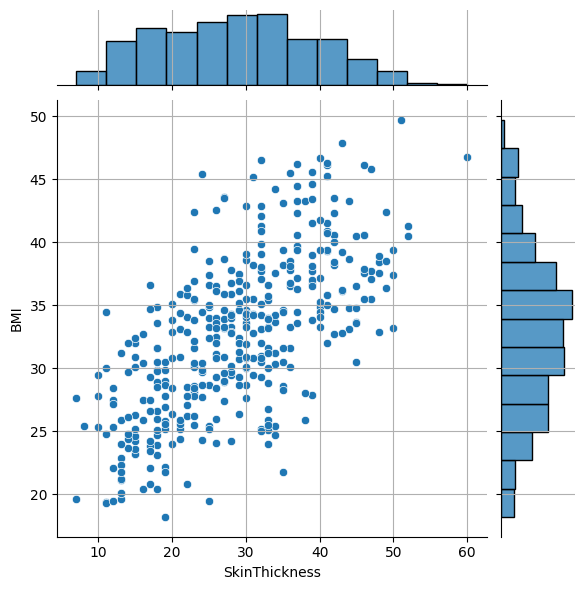

In [126]:
sns.jointplot(df, x="SkinThickness", y="BMI")

In [128]:
# px.scatter(
#     df,
#     x="SkinThickness",
#     y="BMI",
#     trendline="ols",
#     trendline_color_override="red",
# )

In [ ]:
df.describe()

# Problem Statement and Model Setup

## Problem Statement

The data set contains the target feature - median_house_value - and we wish to develop a model from the other features to predict this feature.  

Take 2: using the diabetes data set, make BMI the target feature. I realize the objective of this data set is predicting diabetes, not BMI, but I was interested in a numeric, not categorical feature, so I somewhat arbitrarily decided to check if I could predict BMI given the other features.

## Model Setup

We will establish a pipeline of:
- Polynomial features
- Standardization
- Ridge Regression

and declare the hyperparameter of interest to be the alpha parameter for ridge.

We also saw that polynomial performance (more so on higher-order models) suffered unless the data was scaled prior to doing the polynomial feature transformation, so we will scale the data up front once.

### Defining Target and Regression Features

In [ ]:
target_feature = "BMI"

In [135]:
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
numeric_features.remove("Outcome")
numeric_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Age']

### Standardize

In [136]:
df_zscores = df.copy(deep=True)
df_zscores[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
df_zscores.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,-0.729083,-1.084970,-0.372496,-0.572155,-0.526703,28.1,-1.052109,-0.973617,0
4,-1.040396,0.477103,-2.520986,0.594316,0.110058,43.1,5.315613,0.198976,1
6,-0.106459,-1.442945,-1.694644,0.302698,-0.578332,31.0,-0.808929,-0.485036,1
8,-0.417771,2.429694,-0.041959,1.566374,3.336884,30.5,-1.079129,2.153298,1
13,-0.729083,2.169349,-0.868302,-0.572155,5.944159,30.1,-0.358595,2.739594,1


In [137]:
df_zscores.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,386.000000,3.860000e+02,3.860000e+02,386.000000
mean,4.601961e-17,1.484132e-16,4.256814e-16,2.761176e-17,2.070882e-17,32.708549,1.104471e-16,1.840784e-17,0.326425
std,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,6.358559,1.001298e+00,1.001298e+00,0.469513
min,-1.040396e+00,-2.158895e+00,-3.843134e+00,-2.127448e+00,-1.206487e+00,18.200000,-1.298292e+00,-9.736166e-01,0.000000
25%,-7.290835e-01,-7.595377e-01,-7.030332e-01,-7.665663e-01,-6.794392e-01,28.325000,-7.458821e-01,-7.781845e-01,0.000000
50%,-4.177713e-01,-1.086740e-01,-4.195935e-02,1.108046e-02,-2.556493e-01,33.100000,-2.129870e-01,-3.873202e-01,0.000000
75%,5.161653e-01,6.723624e-01,6.191145e-01,6.915214e-01,2.993647e-01,36.875000,4.910351e-01,4.921245e-01,1.000000
max,4.251912e+00,2.462238e+00,3.263410e+00,3.024462e+00,5.944159e+00,49.700000,5.438704e+00,4.889348e+00,1.000000


### Split into Training and Development

In [166]:
all_inds = shuffle(range(len(df_zscores)), random_state=42)
(train_inds, dev_inds) = np.split(all_inds, [int(0.7 * len(df_zscores))])
display([train_inds[:10], dev_inds[:10]])

# Perform the split using same method as will use in sklearn / SFS
X_train = df_zscores[numeric_features].iloc[train_inds]
y_train = df_zscores.iloc[train_inds][target_feature]
X_dev = df_zscores[numeric_features].iloc[dev_inds]
y_dev = df_zscores.iloc[dev_inds][target_feature]

[array([336, 307,  90, 265, 150, 297,  78, 101, 312,  33]),
 array([256, 356, 100, 226, 329, 213, 171,  98, 215,  61])]

### Build Pipeline

In [139]:
degree = 2
estimator = Pipeline(
    [
        ("transform", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("regression", Ridge()),
    ]
)

### Specify Hyperparameter Search

In [213]:
alpha_list = 10 ** np.linspace(-5, 5, 51)

In [141]:
train_rmse = []
dev_rmse = []

for alpha in alpha_list:
    model = Pipeline(
        [
            ("transform", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scale", StandardScaler()),
            ("regression", Ridge(alpha=alpha)),
        ]
    ).fit(X_train, y_train)
    train_rmse.append(root_mean_squared_error(model.predict(X_train), y_train))
    dev_rmse.append(root_mean_squared_error(model.predict(X_dev), y_dev))

In [142]:
best_dev_rmse = np.min(dev_rmse)
best_alpha = np.array(alpha_list)[np.array(dev_rmse) == best_dev_rmse][0]

In [143]:
best_dev_rmse

5.1853457279583015

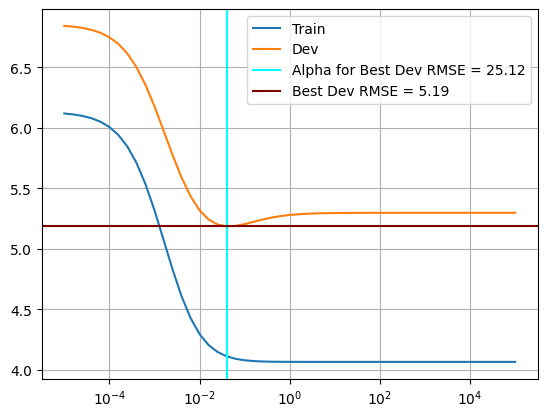

In [212]:
plt.plot(1.0 / alpha_list, train_rmse, label="Train")
plt.plot(1.0 / alpha_list, dev_rmse, label="Dev")
plt.axvline(
    x=1.0 / best_alpha,
    color="cyan",
    label="Alpha for Best Dev RMSE = %.2f" % best_alpha,
)
plt.axhline(
    y=best_dev_rmse,
    color="maroon",
    label="Best Dev RMSE = %.2f" % best_dev_rmse,
)
plt.xscale("log")
plt.legend()

# Results Plotter Function

In [221]:
def score_plot(grid_object, alpha_list):
    best_alpha = grid_object.best_params_["regression__alpha"]
    best_score = -grid_object.cv_results_["mean_test_score"][alpha_list == best_alpha]

    plt.plot(
        1.0 / alpha_list,
        -grid_object.cv_results_["mean_test_score"],
        label="Dev",
    )
    plt.xscale("log")
    plt.axvline(
        x=1.0 / best_alpha,
        color="cyan",
        label="Alpha for Best Score = %.2f" % best_alpha,
    )
    plt.axhline(
        y=best_score,
        color="maroon",
        label="Best Dev Score = %.2f" % best_score,
    )

    plt.xlabel("1/Alpha")
    plt.ylabel("Negative of Mean Test Score")
    plt.legend()

# Cross Validation with Holdout

In [ ]:
param_grid = {"regression__alpha": alpha_list}
grid_search_holdout = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(df_zscores[numeric_features], df_zscores[target_feature])

In [218]:
best_alpha == grid_search_holdout.best_params_["regression__alpha"]

False

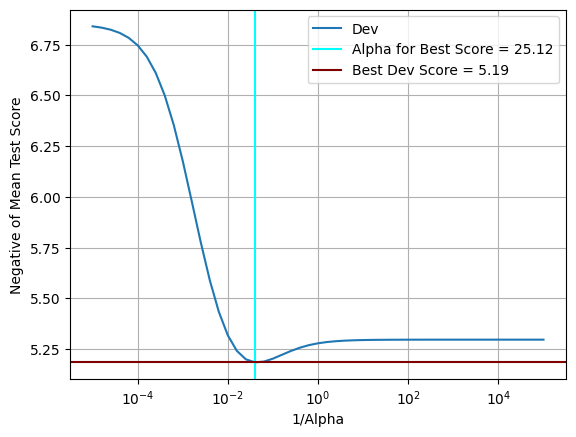

In [226]:
score_plot(grid_search_holdout, alpha_list)

# Cross Validation with K-Fold

In [150]:
grid_search_kfold = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=10,
).fit(df_zscores[numeric_features], df_zscores[target_feature])

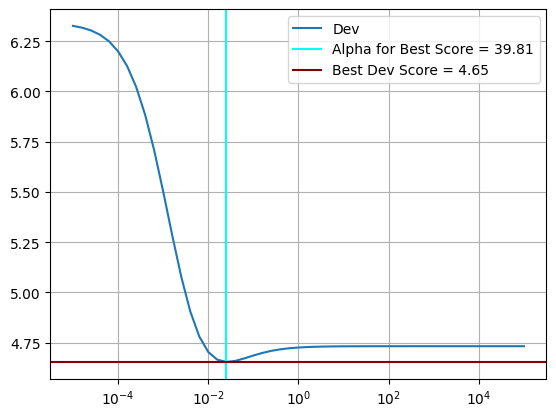

In [204]:
score_plot(grid_search_kfold, alpha_list)

# Cross Validation with Leave One Out

In [154]:
grid_search_loo = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=len(df_zscores),
).fit(df_zscores[numeric_features], df_zscores[target_feature])

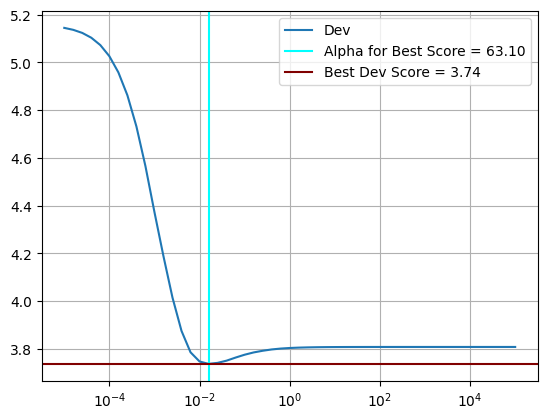

In [205]:
score_plot(grid_search_loo, alpha_list)

# Comparisons and Conclusions

Text(0, 0.5, 'Negative of Mean Test Score')

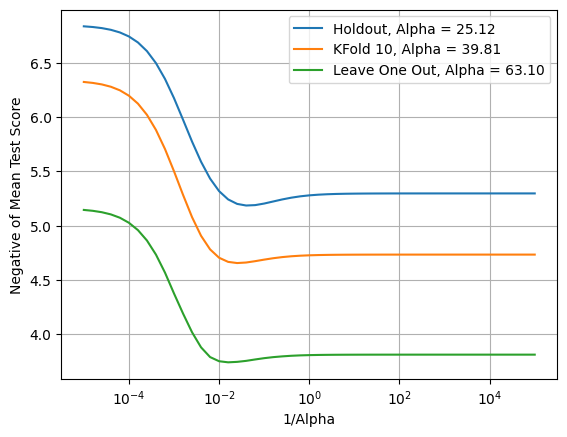

In [227]:
def prep_score(grid_object):
    y = -grid_object.cv_results_["mean_test_score"]
    return y  # - np.min(y)


def plotfun(grid_object, label):
    best_alpha = grid_object.best_params_["regression__alpha"]
    plt.plot(
        1.0 / alpha_list,
        prep_score(grid_object),
        label="%s, Alpha = %.2f" % (label, best_alpha),
    )


plotfun(grid_search_holdout, "Holdout")
plotfun(grid_search_kfold, "KFold 10")
plotfun(grid_search_loo, "Leave One Out")

plt.xscale("log")
plt.legend()
plt.xlabel("1/Alpha")
plt.ylabel("Negative of Mean Test Score")